# Mass-Spring-Damper demo
In this notebook we demonstrate simulation and control of a [mass-spring-damper system](https://en.wikipedia.org/wiki/Mass-spring-damper_model). The system can be described as a weight connected to a ceiling by spring (and damper), where the only thing we can observe is positional displacement $x$. The evolution of the mass-spring-damper system is described by differential equations. 

The simulation of the mass-spring-damper system requires numerical solution of differential equations. Furthermore, we demonstrate the internal model learning to control the periodic positional dispacement. The internal model has to represent the periodic state by phase embedding method, train the linear model and infer the appropriate control.

Therefore the goal of this notebook is twofold:

    1. Introduce the reader with the DynSys framework for numerical ODE solving
    2. Demonstrate the signal embedding, forward model learning, and control. 


## Mass-Spring-Damper model
Lets have an object of mass $m$ that moves on axis $x$. The object is linked to ground by string with stiffness $k$ and by damper with damper ratio $c$. The object is pushed by an external force $F_{external}$. This system is known as [mass-spring-damper](https://en.wikipedia.org/wiki/Mass-spring-damper_model) which is modelled with the following differential

$-kx - c\dot x + F_{external} = m\ddot x$

which we rewrite into first order differential

$
\dot x = v\\ 
\dot v = -\frac{k}{m} x - \frac{c}{m} v + u
$

where $u = \frac{F_{external}}{m}$ is rescaled external force.

We will now implement simulation of the mass-spring-damper.

In [2]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from dynsys_framework.execution_helpers.model_executor_parameters import ModelExecutorParameters
from utils import experiment_helpers
from utils import records



In [3]:
# Mass-Spring-Damper model


def mass_spring_damper_d(xv, u, k_param=2, c_param=1, m_param=5):
    xv_d = np.zeros((1,2))
    xv_d[0, 0] = xv[0, 1]
    xv_d[0, 1] = - (k_param/m_param) * xv[0, 0] - (c_param/m_param) * xv[0, 1] + u
    return xv_d

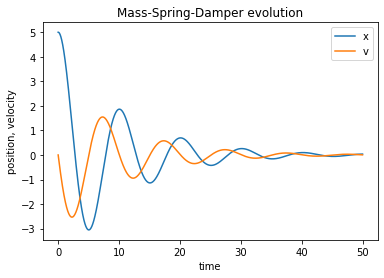

In [4]:
# Euler's method for numerical integration
step_size = 0.01
xvs = [np.asarray([5, 0]).reshape((1,2))]
ts = [0]
for i in range(5000):
    xvs.append(xvs[-1] + mass_spring_damper_d(xvs[-1], 0) * step_size)
    ts.append(ts[-1] + step_size)   
xvs = np.asarray(xvs)
ts = np.asarray(ts)

# plotting result    
plt.plot(ts, xvs[:, 0, 0], label="x")
plt.plot(ts, xvs[:, 0, 1], label="v")
plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper evolution")
plt.legend()
plt.show()

## DynSys Framework implementation
The above implemented Euler's method works fine; however, for more complex systems with tens of variables, the implementation would become cumbersome and the code would be hard to manage. In the following code snippets we will show, how the numerical integration is specified within the *dynsys_framework*.


In [5]:
step_size = 0.01
iterations = 5000
results_path = "results"
if not os.path.exists(results_path):
    os.makedirs(results_path)

# 1. Creating the model composed of linearly growing time and the mass-spring-damper

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# variable "t" : Time 
mep.add("d_t", # name of the variable (with prefix "d_" because it is being numerically integrated)
        (), # the differential needs no inputs
        lambda: 1, # time grows proportionally to integration steps
        default_initial_values={"t": 0} # time starts at 0
       )

# variable "xv": Mass-spring-damper state 
mep.add("d_xv", # name of the variable
        ("xv", "u"), # the differential needs state "xv" and external force "u"
        mass_spring_damper_d, # function taking two inputs computing the differential 
        default_initial_values={"xv": np.asarray([5, 0]).reshape((1,2))} # initial state
       )

# variable "u": external force (is a constant zero)
mep.add("u", # name of the variable, note since it is not differential it has no "d_" prefix.
        (), # no inputs needed
        lambda: 0. # its value is always zero
       )


# 2. Execution initialization
mod_exec = experiment_helpers.build_executor(mep, step_size)

# 3. Running the model simulation which will be saved into "results/msd_run.hdf5"
experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_run")

iter: 0, t: 0, cmp_time: 0.00012111663818359375
iter: 1000, t: 9.999999999999831, cmp_time: 0.02990889549255371
iter: 2000, t: 20.000000000000327, cmp_time: 0.02637338638305664
iter: 3000, t: 30.00000000000189, cmp_time: 0.026015281677246094
iter: 4000, t: 40.00000000000061, cmp_time: 0.024875164031982422
time: 0.13282513618469238


In [5]:
# Reading the experiment results from "results/msd_run.hdf5"
rec = records.load_records(os.path.join(results_path, "msd_run.hdf5"))[0]

records.print_record_shapes(rec)
# See that all variables and their derivations are stored in the hdf5 file
# name          shape

d_t:          (5000,)
d_xv:          (5000, 1, 2)
t:          (5000,)
u:          (5000,)
xv:          (5000, 1, 2)


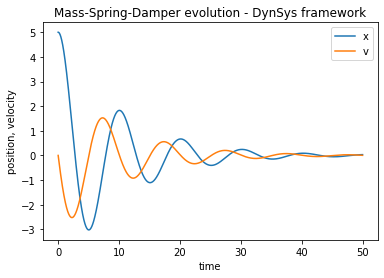

In [6]:
# the recorded variables are accessed by their names (rec is a python dictionary)
plt.plot(rec["t"], rec["xv"][:, 0, 0], label="x")
plt.plot(rec["t"], rec["xv"][:, 0, 1], label="v")
plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper evolution - DynSys framework")
plt.legend()
plt.show()

### Forced mass-spring-damper system
Lets add some external force into our system.

In [7]:
step_size = 0.01
iterations = 5000
results_path = "results"

# 1. Creating the model composed of linearly growing time and the mass-spring-damper

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# variable "t" : Time 
mep.add("d_t", (), lambda: 1, default_initial_values={"t": 0})

# variable "xv": Mass-spring-damper state 
mep.add("d_xv", ("xv", "u"), lambda _xv, _u: mass_spring_damper_d(_xv, _u, k_param=20, c_param=20, m_param=0.1),
        default_initial_values={"xv": np.asarray([0, 0]).reshape((1,2))} 
       )


# variable "u": external force 
mep.add("u", "t", lambda _t: np.maximum(np.sin(_t*1)-0.8, 0))


# 2. Execution initialization
mod_exec = experiment_helpers.build_executor(mep, step_size)

# 3. Running the model simulation which will be saved into "results/msd_run.hdf5"
experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_forced_run")

iter: 0, t: 0, cmp_time: 0.00011110305786132812
iter: 1000, t: 9.999999999999831, cmp_time: 0.04041862487792969
iter: 2000, t: 20.000000000000327, cmp_time: 0.039014339447021484
iter: 3000, t: 30.00000000000189, cmp_time: 0.0396115779876709
iter: 4000, t: 40.00000000000061, cmp_time: 0.03839564323425293
time: 0.1948375701904297


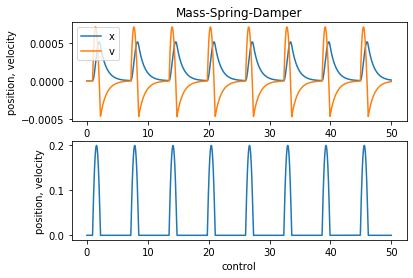

In [8]:
# Reading the experiment results from "results/msd_run.hdf5"
rec = records.load_records(os.path.join(results_path, "msd_forced_run.hdf5"))[0]
# the recorded variables are accessed by their names (rec is a python dictionary)
plt.subplot(211)
plt.plot(rec["t"], rec["xv"][:, 0, 0], label="x")
plt.plot(rec["t"], rec["xv"][:, 0, 1], label="v")

plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper")
plt.legend()
plt.subplot(212)
plt.plot(rec["t"], rec["u"], label="u")
plt.xlabel("control")
plt.ylabel("position, velocity")

plt.show()

## Phase embedding and Internal Model learning to control
Lets say, that we have been given a repeating position **target trajectory** $x^*(t)=x^*(t+T)$ which we want to observe on our mass-spring-damper $x^*(t) \approx x(t)$. We are able to command the external force $u$ and observe its position $x$. However, **we don't know the dynamic relation between external force $u$ and the observed position $x$**. 

We will use the internal model bootstrapping to explore the sensory-motor dynamics. After a sufficient model is trained, the periodic command signal (gait) is synthesised to approach the desired behavior $x^*$. First, run the following snippet.

In [15]:
import models.limit_cycle_controller_contextual as M
results_path = "results"

step_size = 0.01    # step size of numeric integration
iterations = 60000  # number of numeric integration steps
granularity = 8     # Embedding granularity (number of segments per period)

pos_rescale = 2000

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# MASS-SPRING-DAMPER

# variable "t" : Time 
mep.add("d_t", (), lambda: 1, default_initial_values={"t": 0})

# variable "xv": Mass-spring-damper state 
mep.add("d_xv", ("xv", "u"), lambda _xv, _u: mass_spring_damper_d(_xv, _u, k_param=20, c_param=20, m_param=0.1), 
        default_initial_values={"xv": np.asarray([0, 0]).reshape((1,2))})

# variable "x*": Target
mep.add("x*",("t"),lambda _t: np.sin(_t))



# BOOTSTRAPPING CONTROLLER

M.model(mep,
          epicycle_size=16, phase_velocity=1,
          motor_dim=1, motor_segments_num=granularity,
          sensory_dim=1, sensory_segments_num=granularity,
          context_num=3,
          model_quality_lower_bound=1e0, model_quality_upper_bound=1e1,
          performance_quality_upper_bound=2e1,
          perturbation_probability=0.1,
          is_model_learned=True,
          is_control_learned=True, 
          is_model_lr_external=True,
          dynamic_outer_threshold=False,
          regularization_name="u_regularization",
          q_mean_up_lr=0.001, q_mean_down_lr=0.08, u_exp_act_lr=1e-6
          )

# COUPLING THE BOOTSTRAPPING CONTROLLER WITH MASS-SPRING-DAMPER

# variable "x_observed": observed position (taken from the mass-spring-damper state)
mep.add("x_observed", "xv", lambda xv: xv[0, 0] * pos_rescale)
# sensory input
mep.add(M.SENSORY_INPUT, "x_observed", lambda x: x.reshape(1, 1))
# motor command
mep.add("u", M.MOTOR_COMMAND, lambda u: u)
# target embedding
mep.add("d_" + M.SENSORY_REFERENCE, (M.SENSORY_REFERENCE, "x*", M.MOTOR_PHASE_ACTIVATOR), 
        lambda _y_ref, _x_trg, _a: np.einsum("imjd,id->imjd",_x_trg - _y_ref, _a),
        default_initial_values={M.SENSORY_REFERENCE: np.zeros((1,1,1,granularity))}
       )

# learning rage
mep.add(M.MODEL_LEARNING_RATE, "t", lambda _t: 0. if _t<100. else 10.)


# DEFAULT SETUP
# CPG setup
mep.add(M.MOTOR_PERTURBATION, (), lambda: 0)
mep.add(M.STATE_PERTURBATION, (), lambda: 0)
# The set of variables
mep.add("u_regularization", (), lambda: 0.)
# advanced target setup 
y_mask = np.ones((1, 1, 1, granularity))
y_mask_minmax = np.zeros((1, 1, 1, granularity))
mep.add(M.SENSORY_REFERENCE_MASK, (), lambda : y_mask)
mep.add(M.SENSORY_REFERENCE_MINMAX_MASK, (), lambda : y_mask_minmax)


# Build executor and run
mod_exec = experiment_helpers.build_executor(mep, step_size)
experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_bootstrapping_run")

iter: 0, t: 0, cmp_time: 0.004478931427001953
iter: 1000, t: 9.999999999999831, cmp_time: 3.4436004161834717
iter: 2000, t: 20.000000000000327, cmp_time: 3.6184418201446533
iter: 3000, t: 30.00000000000189, cmp_time: 3.5675017833709717
iter: 4000, t: 40.00000000000061, cmp_time: 3.520563840866089
iter: 5000, t: 49.99999999999862, cmp_time: 3.6449942588806152
iter: 6000, t: 59.99999999999663, cmp_time: 3.659167528152466
iter: 7000, t: 69.9999999999989, cmp_time: 3.7370665073394775
iter: 8000, t: 80.00000000000402, cmp_time: 3.58103084564209
iter: 9000, t: 90.00000000000914, cmp_time: 3.83720064163208
iter: 10000, t: 100.00000000001425, cmp_time: 3.691474199295044
iter: 11000, t: 110.00000000001937, cmp_time: 3.6304872035980225
iter: 12000, t: 120.00000000002449, cmp_time: 3.736236572265625
iter: 13000, t: 130.00000000002674, cmp_time: 3.7672111988067627
iter: 14000, t: 140.00000000001765, cmp_time: 3.6886162757873535
iter: 15000, t: 150.00000000000855, cmp_time: 3.6654951572418213
iter:

W_mod:          (60000, 1, 1, 8, 8, 3)
W_mod_rms:          (60000, 1, 1, 8, 8, 3)
a_ep:          (60000, 1, 16)
a_m:          (60000, 1, 8)
a_s:          (60000, 1, 8)
b_mod:          (60000, 1, 1, 1, 8, 3)
b_mod_rms:          (60000, 1, 1, 1, 8, 3)
ctx_act:          (60000, 1, 3)
ctx_e_mod:          (60000, 1, 1, 1, 3)
ctx_mod_q:          (60000, 1, 3)
ctx_mod_q_mu:          (60000, 1, 3)
ctx_mod_q_var:          (60000, 1, 3)
ctx_opt_freeze:          (60000, 1, 3)
ctx_opt_hot:          (60000, 1, 3)
ctx_q_th_in:          (60000, 1)
ctx_q_th_out:          (60000, 1)
ctx_sel_cmd:          (60000, 1, 3)
ctx_sel_ctr:          (60000, 1, 3)
ctx_sel_lrn:          (60000, 1, 3)
ctx_state_lrn:          (60000, 1, 3)
ctx_y_est:          (60000, 1, 1, 1, 3)
ctx_y_prev:          (60000, 1, 1, 1)
d_W_mod:          (60000, 1, 1, 8, 8, 3)
d_W_mod_rms:          (60000, 1, 1, 8, 8, 3)
d_b_mod:          (60000, 1, 1, 1, 8, 3)
d_b_mod_rms:          (60000, 1, 1, 1, 8, 3)
d_ctx_act:          (60000, 1, 

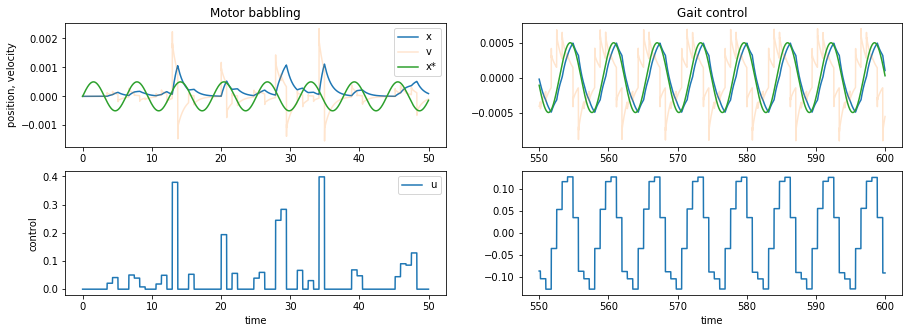

In [16]:
# Reading the experiment results from
rec = records.load_records(os.path.join(results_path, "msd_bootstrapping_run.hdf5"))[0]

# If you want to see all new variables uncomment the following line.
records.print_record_shapes(rec)

# 
plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(221)
plt.plot(rec["t"][:5000], rec["xv"][:5000, 0, 0], label="x")
plt.plot(rec["t"][:5000], rec["xv"][:5000, 0, 1], label="v", alpha=0.2)
plt.plot(rec["t"][:5000], rec["x*"][:5000]/2000, label="x*")

plt.ylabel("position, velocity")
plt.title("Motor babbling")
plt.legend()

plt.subplot(222)
plt.plot(rec["t"][-5000:], rec["xv"][-5000:, 0, 0], label="x")
plt.plot(rec["t"][-5000:], rec["xv"][-5000:, 0, 1], label="v", alpha=0.2)
plt.plot(rec["t"][-5000:], rec["x*"][-5000:]/2000, label="x*")
plt.title("Gait control")

plt.subplot(223)
plt.plot(rec["t"][:5000], rec["u"][:5000, 0, 0], label="u")
plt.xlabel("time")
plt.ylabel("control")
plt.legend()

plt.subplot(224)
plt.plot(rec["t"][-5000:], rec["u"][-5000:, 0, 0], label="u")
plt.xlabel("time")

plt.show()


In the figure above we can see variables we are already familiar with: position $x$, velocity $v$, and control singal $u$; and the target position signal $x^*$. At the start (on the left) the internal model is in *Learning* stage during which the motor babbling is generated as a chaoitc control signal. At the end of the experiment (on the right) the internal model is *Controling* stage where the control signal is synthesised to approach the target position $x(t)\approx x^*(t)$. 

Now lets look into some variables defining the just trained internal model.

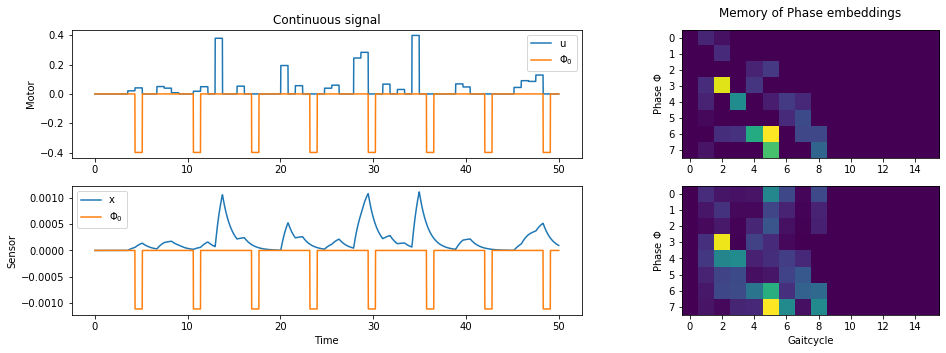

In [17]:
u_mem = rec[M.MOTOR_MEMORY]
y_mem = rec[M.SENSORY_MEMORY]

# plt.subplot(221)
# plt.matshow(u_mem[5000, 0, 0, 0, :, :])
ax = plt.subplot(2, 2, 1)
plt.plot(rec["t"][:5000], rec["u"][:5000, 0, 0], label="u")
plt.plot(rec["t"][:5000], -rec[M.MOTOR_PHASE_ACTIVATOR][:5000, 0, 0]*np.max(rec["u"][:5000, 0, 0]), label="$\Phi_0$")
plt.title("Continuous signal")
plt.ylabel("Motor")
plt.legend()

ax = plt.subplot(2, 2, 3)
plt.plot(rec["t"][:5000], rec["xv"][:5000, 0, 0], label="x")
plt.plot(rec["t"][:5000], -rec[M.MOTOR_PHASE_ACTIVATOR][:5000, 0, 0]*np.max(rec["xv"][:5000, 0, 0]), label="$\Phi_0$")
plt.ylabel("Sensor")
plt.xlabel("Time")
plt.legend()


ax = plt.subplot(2, 2, 2)
ax.matshow(u_mem[5000, 0, 0, 0, :, :])
ax.xaxis.set_ticks_position('bottom')
plt.ylabel("Phase $\Phi$")
plt.title("Memory of Phase embeddings")

ax = plt.subplot(2, 2, 4)
ax.matshow(y_mem[5000, 0, 0, 0, :, :])
ax.xaxis.set_ticks_position('bottom')
plt.ylabel("Phase $\Phi$")
plt.xlabel("Gaitcycle")
plt.tight_layout()
plt.show()


Above the plots demonstrate the transformation of the continuous signals (left) into the **memory of phase embeddings** (right). The continuous signal is segmented by **phase activations** $\Phi_0 \dots \Phi_7$ (eight activations correspond to the set granularity). Only $\Phi_0$ is shown, where the the signal value during $\Phi_0\neq0$ is embedded into memory, which can be observed in the first row of the memory matricies. The memory can remember up to 16 gaitcycles. 

The motor and sensory memories are used to update the sensory-motor model. From motor memory we can extract phase embedding $\nu\in\mathbb R^8$ which corresponds to one sensory measurement in the sensory memory. For example the second column of motor memory corresponds to the first element in third column of the sensory memory. We model such relation linearly:

$\hat x(\Phi_0) = b_{\Phi_0} + w_{\Phi_0} \nu^T$,

where $x(\Phi_0)$ denotes sensory measurement during $\Phi_0$, and $b_{\Phi_0},w_{\Phi_0}\in\mathbb{R^8}$ are parameters of the linear relation during $\Phi_0$. 

Each phase $\Phi_i$ has its own set of parameters and bellow we show the trained weights $W=[w_{\Phi_0}, \dots, w_{\Phi_7}]$.


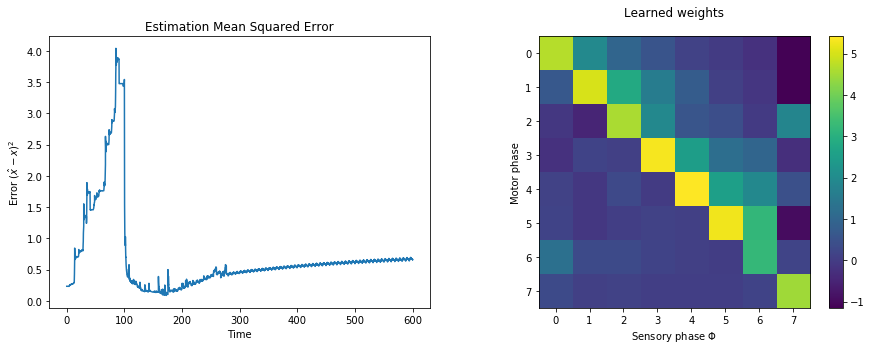

In [18]:
w_mod = rec[M.MODEL_WEIGHTS][-1, 0, 0, :, :, 0]
e_mod = rec[M.MODEL_ERROR][:, 0, 0, 0, :, :, 0]


ax = plt.subplot(1, 2, 1)
ax.plot(rec["t"], np.average(np.sum(np.square(e_mod[:, :, :]), axis=1), axis=1))
ax.set_title("Estimation Mean Squared Error")
ax.set_xlabel("Time")
ax.set_ylabel("Error $(\hat x - x)^2$")

ax = plt.subplot(1, 2, 2)
ax.set_title("Learned weights")
im = ax.matshow(w_mod)
ax.xaxis.set_ticks_position('bottom')

plt.colorbar(im)
ax.set_xlabel("Sensory phase $\Phi$")
ax.set_ylabel("Motor phase")


plt.show()


On the left the estimation error evolution is shown, where the difference between estimation and observation $(\hat x - x)$ is minimized (until the end of *Learning* stage). On the right the learned $W$. The $w_{\Phi_0}$ (first column) shows that the applying positive force at the same phase as the sensory measurement ($\Phi_0$) gives an increase of the position. In fact, this strong positive proportional relation between the motor and sensor at the same phase holds for any phase; see the main diagonal.

During the *Controling* stage, the learned model is used for the motor control inference. Which is done by minimizing the error between target and observation $(x^* - \hat x)$.

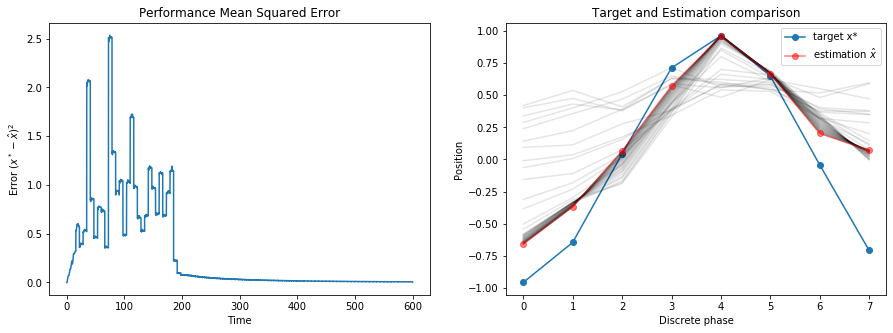

In [19]:
y_embedding = rec["y_est"][:, 0, 0, 0, :, :,0]
y_reference = rec["y_ref"][:, 0, 0, 0, :]
e_mot = rec[M.MOTOR_ERROR][:, 0, 0, 0, :]

plt.subplot(121)
plt.plot(rec["t"], np.average(np.square(e_mot), axis=1))
plt.title("Performance Mean Squared Error")
plt.xlabel("Time")
plt.ylabel("Error $(x^* - \hat x)^2$")

plt.subplot(122)
plt.plot(np.mean(y_reference, axis=0), 'o-', label="target x*")
 
for i in range(15000,y_embedding.shape[0], 1000):
    plt.plot(np.mean(y_embedding[i, :, :], axis=1), '-', color="k", alpha=0.1)

plt.plot(np.mean(y_embedding[-1, :, :], axis=1), 'o-', color="r", label="estimation $\hat{x}$", alpha=0.5)
plt.title("Target and Estimation comparison")
plt.ylabel("Position")
plt.xlabel("Discrete phase")
plt.legend()
plt.show()

On the left, the performance error evolution. The gradual change of the position estimation with position target as a reference is shown on the right. 

The result of the performance error optimization is new motor embedding $\nu$ which is transformed back into the continuous control signal $u$.

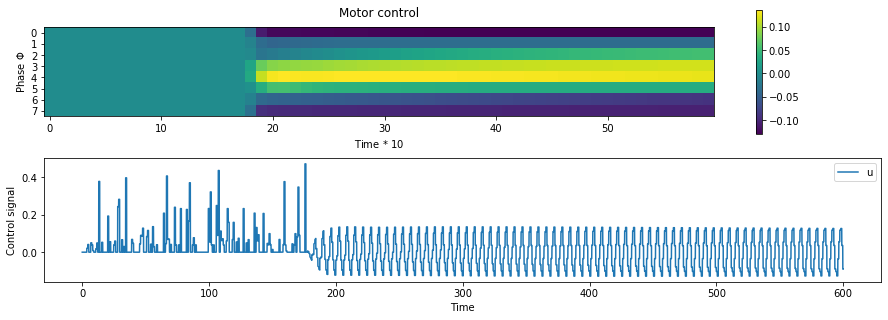

In [20]:
u_out = rec[M.MOTOR_OUTPUT][:, 0, 0, 0, :, 0]

ax = plt.subplot(2, 1, 1)
ax.set_title("Motor control")
im = ax.matshow(u_out[0::1000, :].T)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Phase $\Phi$")
ax.set_xlabel("Time * $10$")
plt.colorbar(im)

ax = plt.subplot(2, 1, 2)
ax.plot(rec["t"], rec["u"][:, 0, 0], label="u")
ax.set_xlabel("Time")
ax.set_ylabel("Control signal")
ax.legend()

plt.show()

On top we can see the evolution of the motor embedding $\nu(t)$. The embedding is then transformed back into the continuous signal $u(t)$ below.